# Project demonstration

This notebook serves as a demonstration of what the toolbox can do. This project is a work in progress, so there will be updates to the code and subsequently the applications. Below are some highlights of what is currently possible.

## Datasets

The starting point of the project is the ability to easily load chemical datasets into a format that is usable from a Machine Learning perspective. All the relevant datasets make use of **SMILES** (Simplified molecular-input line-entry system) to store information on molecules. The in-built DataSets then take the SMILES representation of molecules together with a target array and any other additional information, and load then into **graphs**.

Below are some examples of dataset that can, similarly to the torch datasets, download and load a dataset from the internet.

### LogP dataset

In [1]:
import numpy as np

from grape.datasets import LogP
data = LogP(log=True)

SMILES c1cc(C)ccc1O[Si]12OCCN(CCO1)CCO2 in index 4816 contains the atom Si that is not permitted and will be ignored.
SMILES CC1=CC=C(O[Si]23OCCN(CCO2)CCO3)C=C1 in index 4817 contains the atom Si that is not permitted and will be ignored.
SMILES [H]C1=C([H])C(=C([H])C([H])=C1O[Si]12OC([H])([H])C([H])([H])N(C([H])([H])C([H])([H])O1)C([H])([H])C([H])([H])O2)C([H])([H])[H] in index 4818 contains the atom Si that is not permitted and will be ignored.
SMILES c3cc(C)ccc3O[Si]12OCCN(CCO2)CCO1 in index 4819 contains the atom Si that is not permitted and will be ignored.
SMILES Cc1ccc(cc1)O[Si]12OCCN(CCO1)CCO2 in index 4820 contains the atom Si that is not permitted and will be ignored.
SMILES Cc1ccc(O[Si]23OCCN(CCO2)CCO3)cc1 in index 4821 contains the atom Si that is not permitted and will be ignored.
SMILES c1ccc(Cl)cc1O[Si]12OCCN(CCO1)CCO2 in index 6328 contains the atom Si that is not permitted and will be ignored.
SMILES [H]C1=C([H])C(O[Si]23OC([H])([H])C([H])([H])N(C([H])([H])C([H])([H])O

In [2]:
print(data.smiles[0:5])

['CCC1(c2ccccc2)NC(=O)N(C)C1=O' 'CCC1(c2ccccc2)N=C(O)N(C)C1=O'
 'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1'
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1'
 'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1']


As seen above, the data loader filters the SMILES based a few different criteria. One of them is a check if rdkit recognizes the SMILES representation as valid, another one is the use of a list of *allowed* atom symbols. After filtering, we can access the information using the regular class notations.

### Example outputs

In [3]:
# SMILES
data.smiles[0:5]

array(['CCC1(c2ccccc2)NC(=O)N(C)C1=O', 'CCC1(c2ccccc2)N=C(O)N(C)C1=O',
       'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1',
       'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1',
       'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1'], dtype=object)

In [4]:
# Their corresponding graphs, saved using the torch geometric Data objects.
data[0:5]

[Data(x=[16, 42], edge_index=[2, 34], edge_attr=[34, 12], y=[1]),
 Data(x=[16, 42], edge_index=[2, 34], edge_attr=[34, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1]),
 Data(x=[24, 42], edge_index=[2, 54], edge_attr=[54, 12], y=[1])]

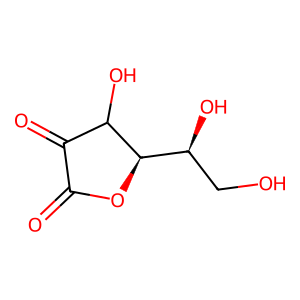

In [5]:
data.draw_smile(10)

In [6]:
# We can also save and load the dataset as such:
#   Dataset are saved using pickle, which allows for fast saving and loading. Saving a dataset and then loading instead of loading from, for example, an excel file is about 10 to 20 times faster.

from grape.utils import DataSet

data.save_dataset('LogP')
loaded_dataset = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/LogP.pickle')
loaded_dataset.smiles[0:5]

File saved at: ./data/processed/LogP.pickle
Loaded dataset.


array(['CCC1(c2ccccc2)NC(=O)N(C)C1=O', 'CCC1(c2ccccc2)N=C(O)N(C)C1=O',
       'CCN(CC)C(O)=C1C=C2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1',
       'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)CC2N(C)C1',
       'CCN(CC)C(=O)C1=CC2c3cccc4[nH]cc(c34)C[C@H]2N(C)C1'], dtype=object)

### Analysis

There are several options to analyze a loaded dataset. Below are some of these options.

#### Compound numbers chart
This chart is generated using a simple clustering algorithm that checks the letter in the SMILES and puts them into the below seen molecule classes. For example, if a SMILES only contains an 'O' and no other class letter, then it is part of 'Oxygenated'. If it contains 'O' and 'Cl', then it is part of 'Multifunctional'.

Loaded dataset.


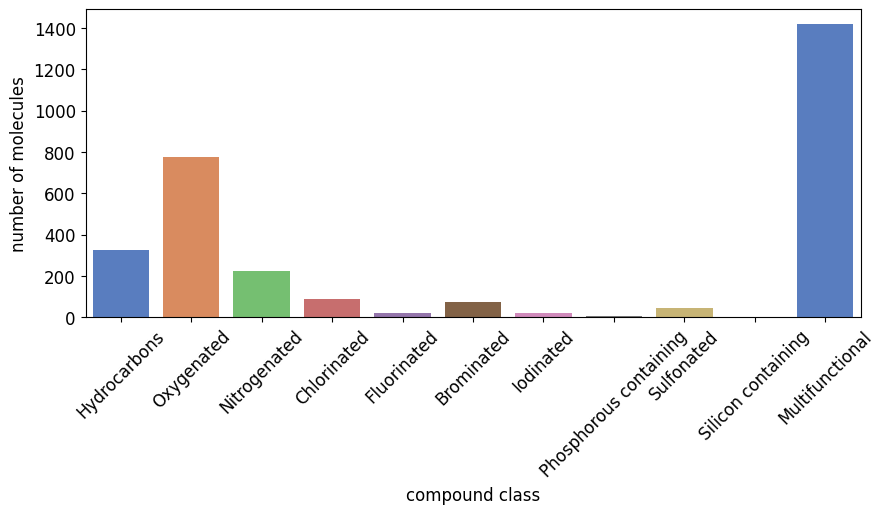

In [7]:
from grape.plots import compound_nums_chart

data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')
compound_nums_chart(data.smiles, fig_size=(10,4))

#### Classyfire
An almost always more useful clustering is using the Classyfire [1] classification done by Feunang et al.. In code terms, we pull the online documentation of the molecules in question with their Classyfire information, read it and cluster them based on that. This approach is far superior over the simple one above, but can take very long to do (it takes about 2 min to retrieve the information for 100 molecules).

In [34]:
subset_smiles = data.smiles[:300]

from grape.analysis import classyfire, classyfire_result_analysis
classyfire(subset_smiles, log=False)
smile_classes, class_num_dictionary = classyfire_result_analysis()
print(class_num_dictionary)

100%|██████████| 260/260 [07:45<00:00,  1.79s/it]

Some InChikeys were not available. Please check "Missing_ichikeys.txt" file.
{'Benzenoids': 210, 'Phenylpropanoids and polyketides': 8, 'Organic nitrogen compounds': 16, 'Organoheterocyclic compounds': 63, 'Organic oxygen compounds': 34, 'Hydrocarbons': 104, 'Acetylides': 3, 'Organohalogen compounds': 46, 'Organic acids and derivatives': 29, 'Lipids and lipid-like molecules': 26, 'Organosulfur compounds': 18, 'Organophosphorus compounds': 2, 'Homogeneous non-metal compounds': 5, 'Alkaloids and derivatives': 1, 'Organic 1,3-dipolar compounds': 1}


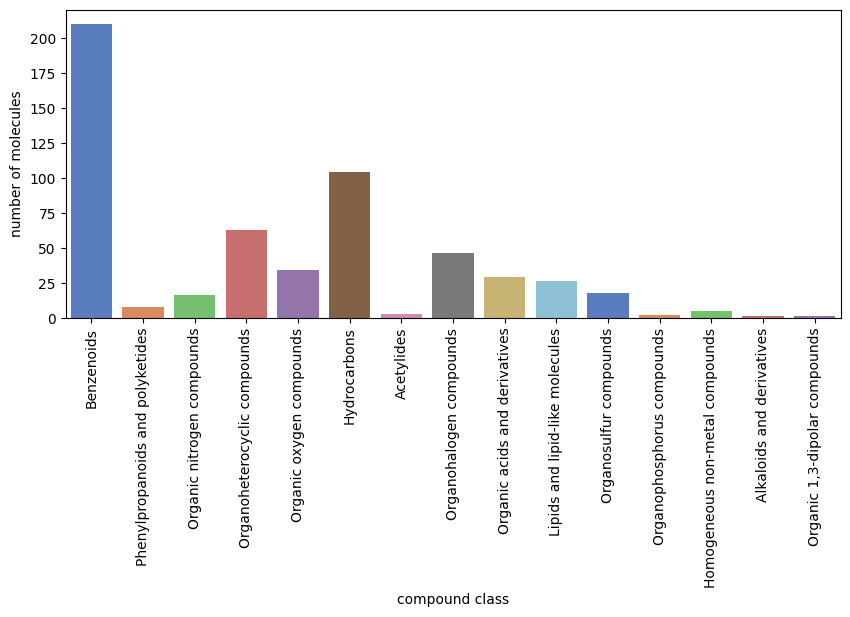

In [35]:
from grape.plots import num_chart
num_chart(class_num_dictionary, fig_size=(10,4))

#### Molecule Weight against Target
Another option for visual analysis is to plot the molecule weight against the target attribute. This might give an indication on how molecule size correlates with the target, often a usual observation.

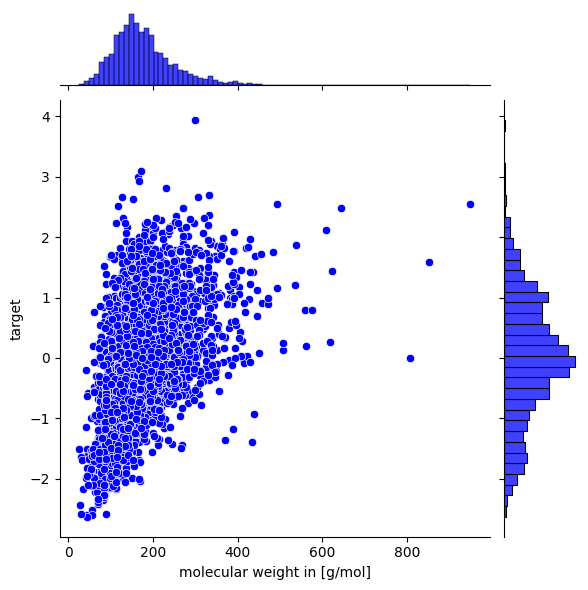

In [32]:
from grape.plots import mol_weight_vs_target
mol_weight_vs_target(data.smiles, data.target, save_fig=True, fig_height=6)

#### Feature number charts
If only a basic analysis of the dataset, is needed, then one can generate number charts based on the featurizion of the molecules. The implementation is built on top of DGL-LIFESCI ```analyze_mols``` function ([github](https://github.com/awslabs/dgl-lifesci/blob/master/python/dgllife/utils/analysis.py)), below is an example.

Loaded dataset.


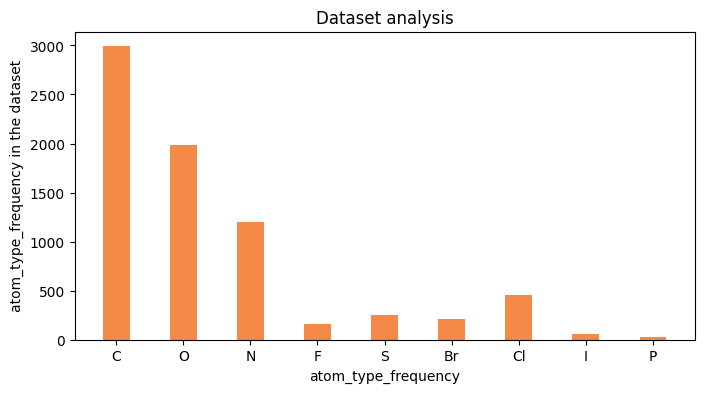

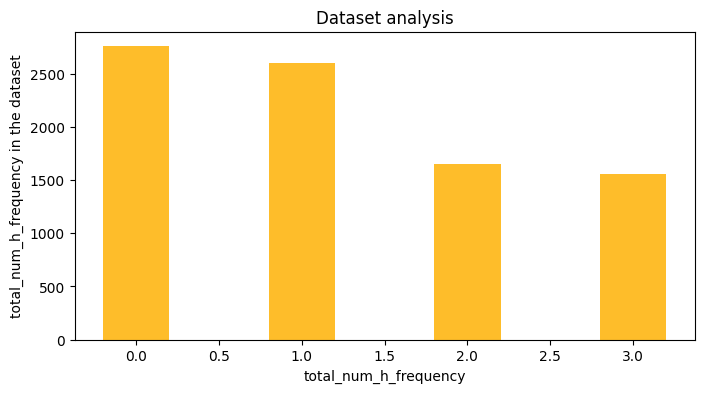

In [11]:
%matplotlib inline

from grape.utils import DataSet
data = DataSet(file_path='/Users/faerte/Desktop/grape/notebooks/data/processed/BradleyDoublePlus.pickle')

results, figures = data.analysis(download=True, plots=['atom_type_frequency','total_num_h_frequency'], fig_size=[8,4],
                                 save_plots=True)

## Clustering and data splitting
There are several ways to split the graph dataset into the training, validation and testing splits, including random, stratified or by molecular weight. A more novel addition is a split based on **Butina clustering** [2], where the molecules are clustered based on the Morgan Fingerprint and the Tanimoto similarity.


In [2]:
from grape.datasets import BradleyDoublePlus
from grape.utils import split_data
data = BradleyDoublePlus()

train, val, test = split_data(data, split_type='butina', random_state=42);

## GNN Model
With the data loaded, filtered, featurizerized and split, let's define a Graph Neural Network and test it! We can always find the number of features like thus:

In [3]:
print(f'Node feature dimension: {data.num_node_features}')
print(f'Edge feature dimension: {data.num_edge_features}')

Node feature dimension: 42
Edge feature dimension: 12


#### Model definition
To define a model, all we need is the Message Passing Network (like Weave) and a output model. Below, we call the Weave network and wrap it in the ```SimpleGNN``` module, that just adds a global pooling and output layer to the Message Passing network.

In [4]:
from grape.models import MPNN, SimpleGNN
from torch import nn
import torch

node_hidden_dim = 128
batch_size = 32

model_message = MPNN(num_layers=5, edge_hidden_dim=128, node_hidden_dim=node_hidden_dim, 
                node_in_dim=data.num_node_features, edge_in_dim=data.num_edge_features)

out_model = nn.Sequential(
    nn.Linear(node_hidden_dim, 128),
    nn.ReLU(),
    nn.Linear(128, 1)
)


model = SimpleGNN(model_message=model_message,
                  out_model=out_model)
                  

print(model)

device = torch.device('cpu')

SimpleGNN(
  (model_message): MPNN(
    (lin_in): Linear(in_features=42, out_features=128, bias=True)
    (gru): GRU(128, 128, num_layers=10)
    (mlp): Sequential(
      (0): Linear(in_features=12, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
    (gnn_layers): ModuleList(
      (0-4): 5 x NNConv(128, 128, aggr=add, nn=Sequential(
        (0): Linear(in_features=12, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
      ))
    )
  )
  (out): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)


### Loss and Optimizer
Like with any Deep Learning Model, we define a loss function and optimizer.

In [5]:
from torch import nn

loss_func = nn.functional.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)

We can additionally define an Early Stopper to help improve the output:

In [6]:
from grape.utils import EarlyStopping
early_stopper = EarlyStopping(patience=15)

### Training
And then we just use the previous found training and validation splits to train the model inside the ```train_model``` function.

In [7]:
from grape.utils import train_model

train_loss, val_loss = train_model(model = model,
                                   loss_func = loss_func,
                                   optimizer = optimizer,
                                   train_data_loader= train,
                                   val_data_loader = val,
                                   batch_size=batch_size,
                                   epochs=500,
                                   EarlyStop=early_stopper)

  0%|          | 0/500 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 128, 128]' is invalid for input of size 99840

### Loss plot

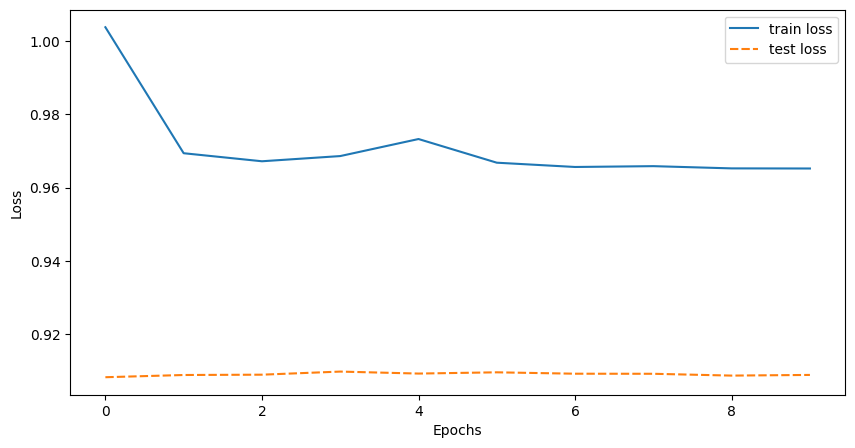

In [17]:
from grape.plots import loss_plot
loss_plot([train_loss, val_loss], ['train loss', 'test loss'])

### Testing

In [18]:
from grape.utils import test_model
test_model(model = model,
           test_data_loader= test,
           loss_func= loss_func);

100%|██████████| 10/10 [00:00<00:00, 168.45it/s]

Test loss: 1.075


### Post Processing

With the trained model, we can examine it closer. One way of checking how good a fit is by comparing different losses like MSE, SSE or MAE and seeing where the model might fail. We begin by extracting the test predictions (and latents for later).

In [19]:
preds, lats = test_model(model=model,
                   test_data_loader=test,
                   loss_func=None,
                   return_latents=True)

100%|██████████| 10/10 [00:00<00:00, 186.69it/s]


Then we calculate some metrics on the predictions:

In [20]:
from grape.utils import pred_metric
pred_metric(prediction=preds,target=test.y, metrics='all', print_out=True);

MSE: 0.967
SSE: 288.251
MAE: 0.771
R2: -0.000
MRE: 12716.386%


We could also choose to plot the parity and residual plots:

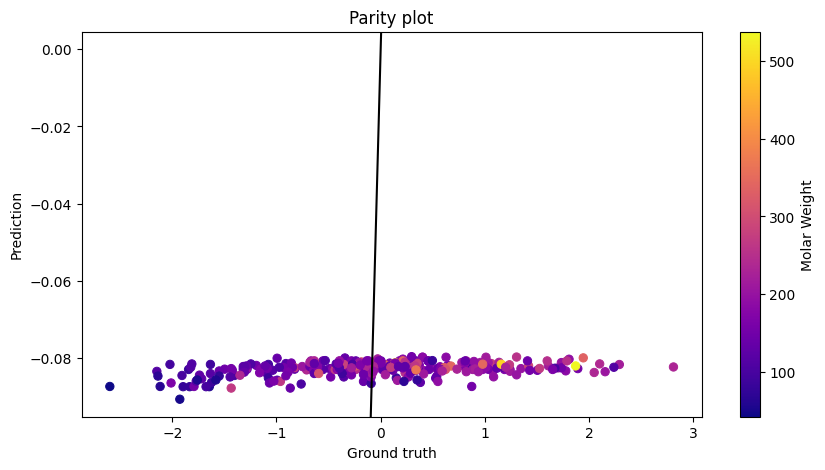

In [21]:
from grape.plots import parity_plot, residual_plot
parity_plot(prediction=preds,target=test.y, mol_weights=test.mol_weights);

<Axes: title={'center': 'Residual plot'}, xlabel='Ground truth', ylabel='Residual'>

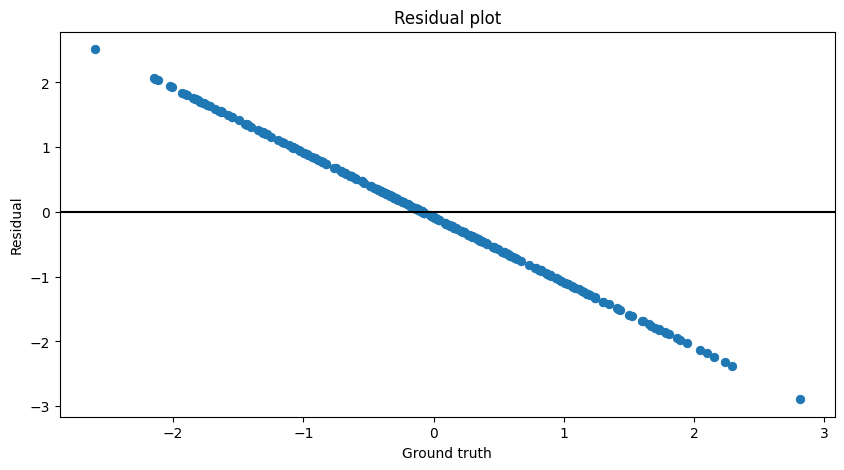

In [22]:
residual_plot(prediction=preds,target=test.y)

Or finally, we could analyze the model latents by applying a PCA model and plotting them based on groups. Let us first classify a subset of our test SMILES and transform the labels into a numeric list for plotting:

In [23]:
from grape.analysis import classyfire, classyfire_result_analysis

ids, data_ids = classyfire(test.smiles, log=False)
# -> ids are used for the result analysis and data_ids for specifying the data point from the test set we can use

class_dict, _ = classyfire_result_analysis(idx=ids, layer=1)

100%|██████████| 298/298 [08:48<00:00,  1.77s/it]


In [24]:
indices = list(class_dict.keys())
labels = list(class_dict.values())
print(labels)

['Phenylpropanoids and polyketides', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Hydrocarbons', 'Benzenoids', 'Benzenoids', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Organic acids and derivatives', 'Organic oxygen compounds', 'Organic acids and derivatives', 'Benzenoids', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Organohalogen compounds', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Organohalogen compounds', 'Benzenoids', 'Organoheterocyclic compounds', 'Benzenoids', 'Organic acids and derivatives', 'Organoheterocyclic compounds', 'Benzenoids', 'Benzenoids', 'Organoheterocyclic compounds', 'Lipids and lipid-like molecules', 'Benzenoids', 'Lipids and lipid-like molecules', 'Organic nitrogen compounds', 'Benzenoids', 'Hydrocarbons', 'Organohalogen compounds', 'Organohalogen compounds', 'Organic acids and derivatives', 'Benzenoids', 'Organic acids and derivatives', 'Benzenoids', 'Benzenoids', 'Benzenoids', 'Organic acids a

Now we can generate the PCA plot:

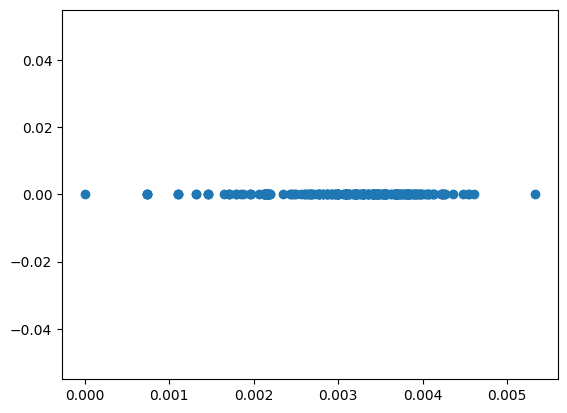

In [25]:
import matplotlib.pyplot as plt
lats = lats.cpu().detach().numpy()
plt.scatter(lats[:,0],lats[:,1])

<Axes: title={'center': "PCA using the two first PC's"}>

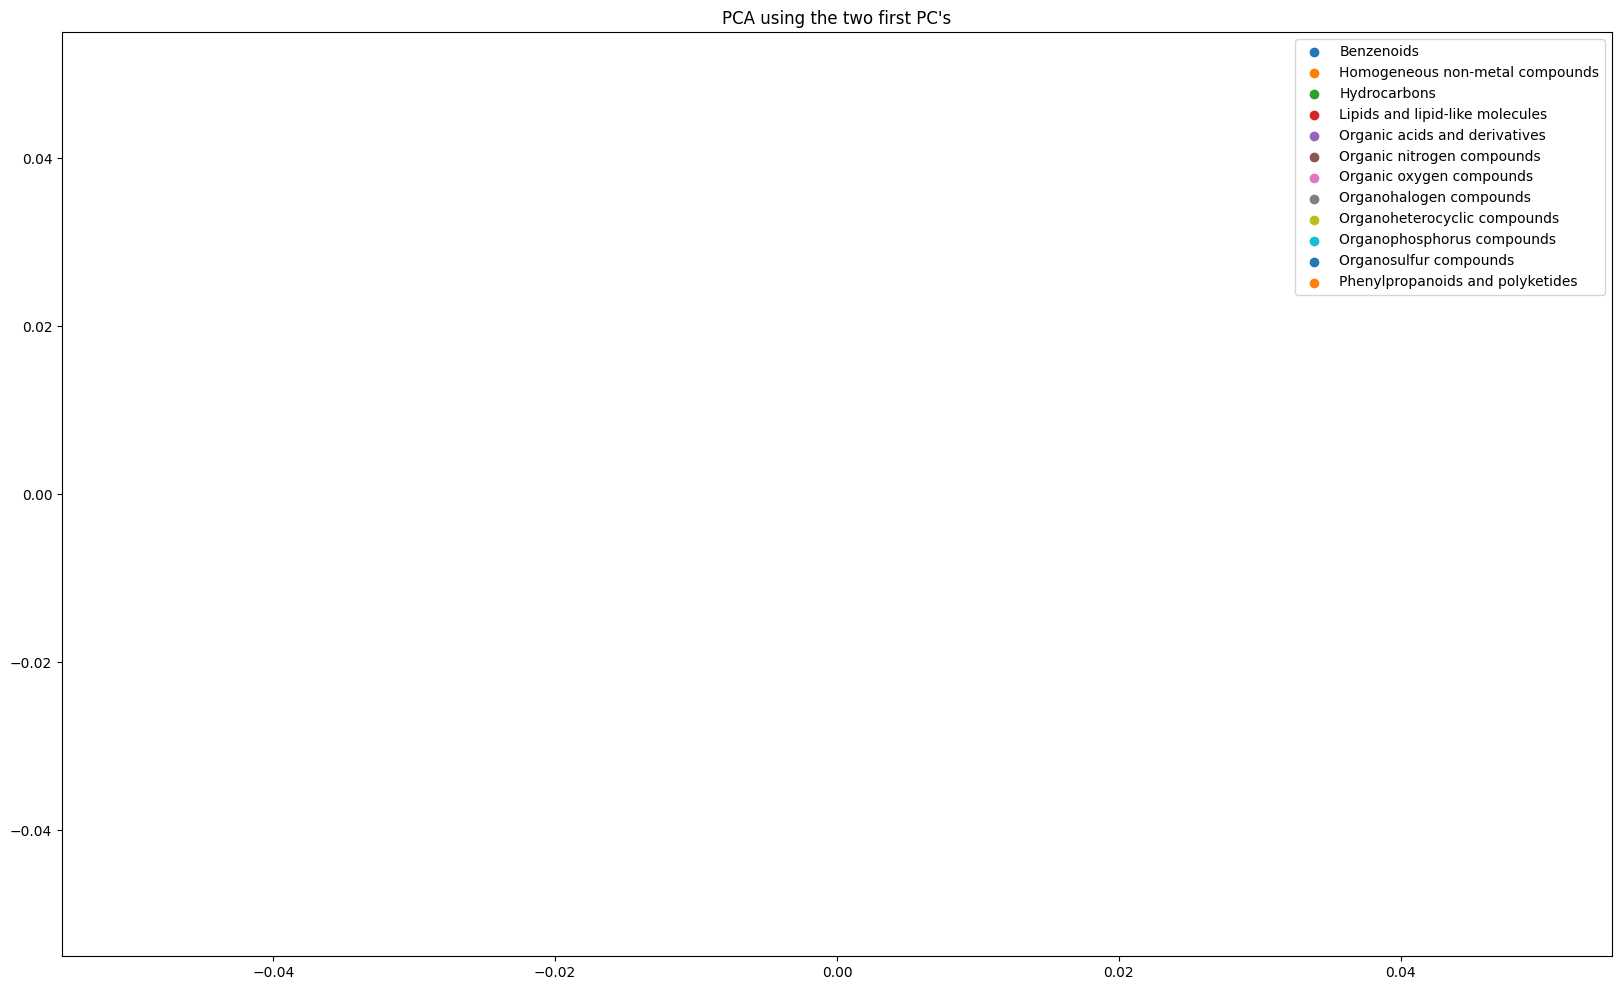

In [26]:
from grape.plots import pca_2d_plot
pca_2d_plot(latents=lats[data_ids], labels=labels, save_fig=True, fig_size=(20,12))

<Axes: title={'center': 't-distributed Stochastic Neighbor Embedding'}>

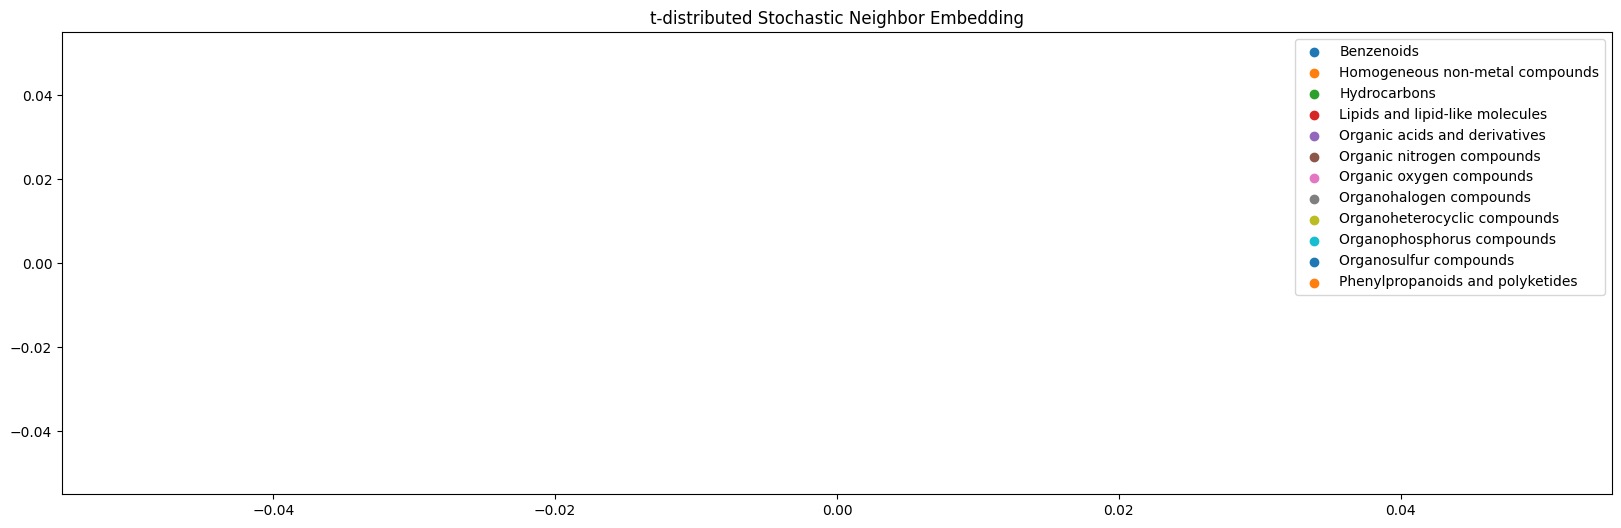

In [27]:
from grape.plots import tSNE_plot
tSNE_plot(latents=lats[data_ids], labels=labels)

-----

**References**

[1] Feunang, Y., Eisner, R., Knox, C., Chepelev, L., Hastings, J., Owen, G., Fahy, E., Steinbeck, C., Subramanian, S., Bolton, E., Greiner, R., & Wishart, D. S. (2016). ClassyFire: automated chemical classification with a comprehensive, computable taxonomy. Journal of Cheminformatics, 8(1), 61. https://doi.org/10.1186/s13321-016-0174-y

[2] Butina, D. (1999). Unsupervised Data Base Clustering Based on Daylight's Fingerprint and Tanimoto Similarity: A Fast and Automated Way To Cluster Small and Large Data Sets. Journal of Chemical Information and Computer Sciences, 39(4), 747-750. https://doi.org/10.1021/ci9803381